<a href="https://colab.research.google.com/github/iamchristophek/Eresultats/blob/master/DeepDR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
import os
os.chdir('drive/My Drive/Colab Notebooks/DimensionalyReduction')

## Trying ACP on Mnist Data

(60000, 784)
(10000, 784)


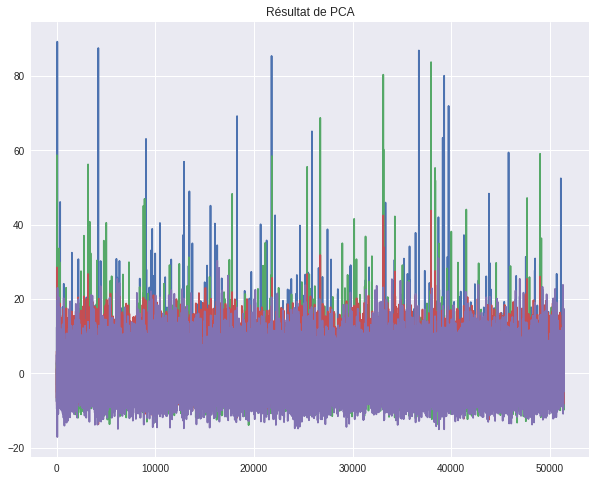

In [36]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from keras.datasets import mnist
import numpy as np

(x_train, train_label), (x_test, test_label) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
train_label = train_label.astype('float32') / 255.
test_label = test_label.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

mnist_target=train_label

mnist_data=x_train


from sklearn.model_selection import train_test_split

train_img, test_img, train_lbl, test_lbl = train_test_split( mnist_data, mnist_target, test_size=1/7.0, random_state=0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train_img)

train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

from sklearn.decomposition import PCA

pca = PCA(4)
pca.fit(train_img[1:100,:])
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

plt.figure(figsize=(10,8))
plt.title('Résultat de PCA')
plt.plot(train_img)

## ACP on IRIS data


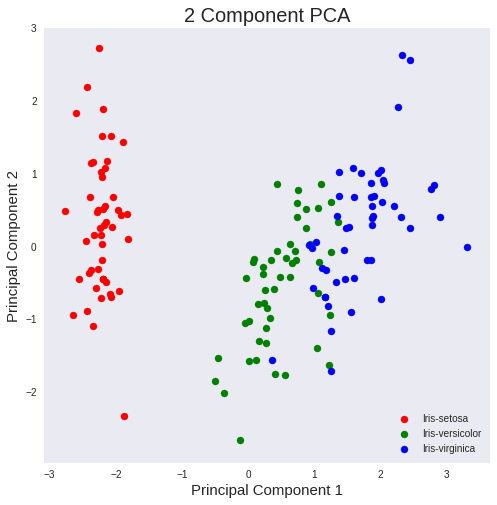

In [37]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

df = pd.read_csv(url
                 , names=['sepal length','sepal width','petal length','petal width','target'])

features = ['sepal length', 'sepal width', 'petal length', 'petal width']
x = df.loc[:, features].values
y = df.loc[:,['target']].values
x = StandardScaler().fit_transform(x)

pd.DataFrame(data = x, columns = features)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df[['target']]], axis = 1)



#visualisation

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Non linear Method: LLE on Digits data

## ** Neighbour seach for LLE weighted matrix construction**

In [0]:
from sklearn.neighbors import NearestNeighbors 
from sklearn import datasets, neighbors
import numpy as np


In [0]:
# we will implement K-nearest neighbor search
def Knbor_Mat(X, K, t = 2.0, dist_metric = "euclidean", algorithm = "ball_tree"):
    
    n,p = X.shape
    
    knn = neighbors.NearestNeighbors(K+1, metric = dist_metric, algorithm=algorithm).fit(X)
    distances, nbors = knn.kneighbors(X)
    
    return(nbors[:,1:])

In [0]:
# calculation of reconstruction weights
from scipy import linalg

def get_weights(X, nbors, reg, K):
    
    n,p = X.shape
    
    Weights = np.zeros((n,n))
    
    for i in range(n):
        
        X_bors = X[nbors[i],:] - X[i]
        cov_nbors = np.dot(X_bors, X_bors.T)
        
        #regularisation
        trace = np.trace(cov_nbors)
        if trace >0 :
            R = reg*trace
        else:
            R = reg
        
        cov_nbors.flat[::K+1] += R
        weights = linalg.solve(cov_nbors, np.ones(K).T, sym_pos=True)

        weights = weights/weights.sum()
        Weights[i, nbors[i]] = weights
        
    return(Weights)


In [0]:
# calculation of the new embedding
from scipy.linalg import eigh

def Y_(Weights,d):
    n,p = Weights.shape
    I = np.eye(n)
    m = (I-Weights)
    M = m.T.dot(m)
    
    eigvals, eigvecs = eigh(M, eigvals=(1, d), overwrite_a=True)
    ind = np.argsort(np.abs(eigvals))
    
    return(eigvecs[:, ind])

In [0]:
#@title
def plotter(K):
    fig = plt.figure(figsize=(10,8))
    Y = LLE_(X , K)
    s = Y[test]
    plt.scatter(Y[:,0],Y[:,1],c=color, cmap=plt.cm.spectral)
    plt.scatter(s[:,0],s[:,1], c="black")

    #interact(plotter, K= widgets.IntSlider(min=10, max=100, value=10, step=10))

[ 877 1365 1541 1167 1029  464  957 1697  855  335]


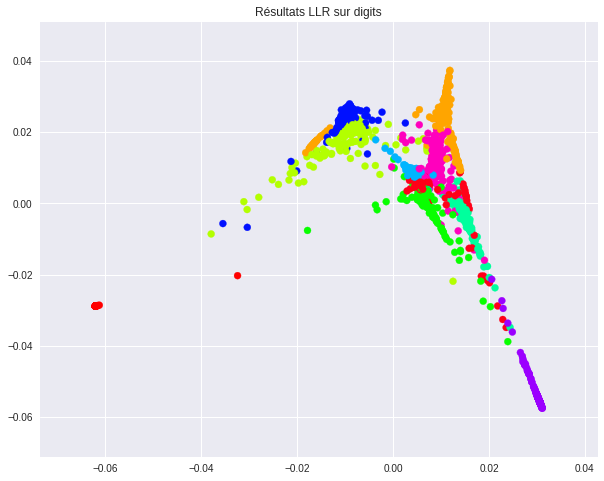

interactive(children=(IntSlider(value=10, description='K', min=10, step=10), Output()), _dom_classes=('widget-…

<function __main__.plotter>

<Figure size 720x576 with 0 Axes>

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn import datasets
data=datasets.load_digits()
import pandas as pd
X=data.data
target=data.target

n_points = 1797
z, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)

def LLE_(X, K):
    reg =0.001
    nbors = Knbor_Mat(X,K)
    print(nbors[0])
    Weights = get_weights(X, nbors, reg,K)
    
    Y = Y_(Weights,2)
    return(Y)
#("black","grey","orange","red","green","pink","blue","m","khaki","plum")

plt.figure(figsize=(10,8))
Y =LLE_(X , 10)

plt.title("Résultats LLR sur digits")
plt.scatter(Y[:,0],Y[:,1],c=target,cmap='hsv')


##**Loss Function for AE**

In [0]:
import math
import numpy as np
 
def Perte(y_true, y_pred):
  batch = len(y_pred)
  for i in range(batch):
    X = K.get_value(y_pred)
    X = X.reshape(28,3)
    lamda = 0.5
    z = encoder.predict(X)
    encoded = encoder.predict(X)
    z = z.reshape((28,3))
    y,W = LLE_(encoded.reshape((28,3)),10)
    produit = np.dot(W,z)
    diff =  z - produit 
    loss_lle = lamda * np.linalg.norm(diff)
    return loss_lle
  
  
def pertefunc(y_true,y_pred):
  loss_lle = Perte(y_true,y_pred)
  cross = K.sum(K.binary_crossentropy(y_true,y_pred), axis=-1)
  return cross + loss_lle

In [0]:
perte = | X - decoded_image|2 + lamda|encoded_image - S*encoded_image|2

In [0]:
def LLE_Function(data):
  dim=(5,3)
  metric = "euclidienne"
  lamb=0.1
  k=10
  
  X= data.reshape(dim)
  
  dist = pairewise_distance(X, metric=metric)
  Affinity= compute_affinity(dist, k)
  

## ** Implementing Autoencoder using Keras **

In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

In [0]:

class Autoencoder(object):
    
    def __init__(self, inout_dim, encoded_dim):    
        input_layer = Input(shape=(inout_dim,))
        hidden_input = Input(shape=(encoded_dim,))
        hidden_layer = Dense(encoded_dim, activation='relu')(input_layer)
        hidden_layer = Dense(encoded_dim, activation='relu')(input_layer)
        output_layer = Dense(784, activation='sigmoid')(hidden_layer)
        
        self._autoencoder_model = Model(input_layer, output_layer)
        self._encoder_model = Model(input_layer, hidden_layer)
        tmp_decoder_layer = self._autoencoder_model.layers[-1]
        self._decoder_model = Model(hidden_input, tmp_decoder_layer(hidden_input))
        
        self._autoencoder_model.compile(optimizer='Adam', loss='mse')
        
    def train(self, input_train, input_test, batch_size, epochs):    
        history=self._autoencoder_model.fit(input_train, 
                                      input_train,
                                    epochs = epochs,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    validation_data=(
                                            input_test, 
                                            input_test),
                                    callbacks=[TensorBoard(log_dir='/tmp/self._autoencoder_model')])
        return history
       
    def getEncodedImage(self, image):
          encoded_image = self._encoder_model.predict(image)
          return encoded_image

    def getDecodedImage(self, encoded_imgs):
          decoded_image = self._decoder_model.predict(encoded_imgs)
          return decoded_image

## Using Now an Linear AutoEncoder on Fashion Mnist

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import fashion_mnist

# Donnée
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 23us/step - loss: 0.0588 - val_loss: 0.0332
Epoch 2/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0284 - val_loss: 0.0249
Epoch 3/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0227 - val_loss: 0.0207
Epoch 4/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0192 - val_loss: 0.0180
Epoch 5/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0170 - val_loss: 0.0162
Epoch 6/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0156 - val_loss: 0.0152
Epoch 7/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0147 - val_loss: 0.0145
Epoch 8/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0142 - val_loss: 0.0141
Epoch 9/10
60000/60000 [==============================] - 1s 19us/step - loss: 0.0139 - val_loss: 0.0138
Epoch

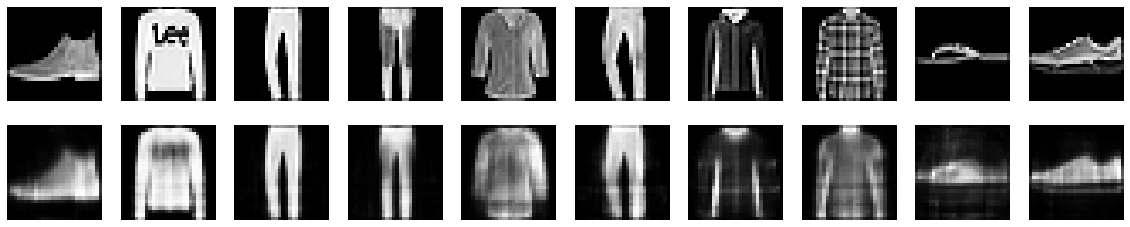

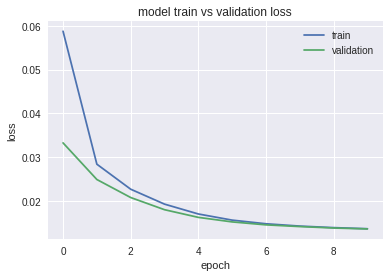

In [54]:


autoencoder = Autoencoder(x_train.shape[1], 32)
history=autoencoder.train(x_train, x_test, 256, 50)
encoded_imgs = autoencoder.getEncodedImage(x_test)
decoded_imgs = autoencoder.getDecodedImage(encoded_imgs)

# Keras implementation results
plt.figure(figsize=(20, 4))
for i in range(10):

    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)


    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [0]:
##

## **AutoEncoder with LLE on Mnist data**

In [0]:
import numpy as np
from tensorflow.keras.datasets import mnist
#from autoencoder_keras import Autoencoder
import matplotlib.pyplot as plt

# Import des données
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0533 - val_loss: 0.0309
Epoch 2/50
60000/60000 [==============================] - 2s 36us/step - loss: 0.0256 - val_loss: 0.0205
Epoch 3/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0183 - val_loss: 0.0159
Epoch 4/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0147 - val_loss: 0.0131
Epoch 5/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0127 - val_loss: 0.0116
Epoch 6/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0116 - val_loss: 0.0109
Epoch 7/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.0110 - val_loss: 0.0105
Epoch 8/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0107 - val_loss: 0.0103
Epoch 9/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0106 - val_loss: 0.0102
Epoch

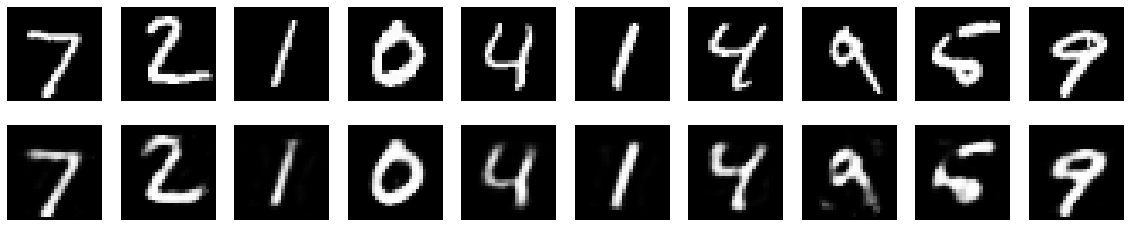

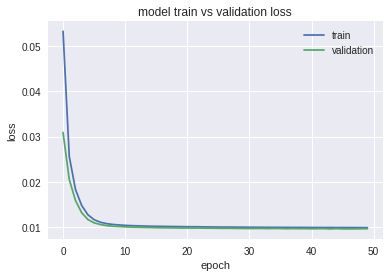

In [77]:

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Keras implementation de l'auto encoder
autoencoder = Autoencoder(x_train.shape[1], 32)
history = autoencoder.train(x_train, x_test, 128, 50)
encoded_imgs = autoencoder.getEncodedImage(x_test)
decoded_imgs = autoencoder.getDecodedImage(encoded_imgs)

# Keras implementation des results
plt.figure(figsize=(20, 4))
for i in range(10):
    # Données Originaux
    subplot = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)

    # Reconstruction des datas
    subplot = plt.subplot(2, 10, i + 11)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    subplot.get_xaxis().set_visible(False)
    subplot.get_yaxis().set_visible(False)
plt.show()
#plt.plot()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [0]:
#Les résultats obténus ne sont pas aussi bon. Le but de l exercice en effet etant de performer cette étape avec les nouveau poids obtenu a chaque fois avec la fonction objective, nous aurions eu sans doute de meilleurs
#resultats.
#Néamoins , allons jusqu au bout et voyons ce que nous offre Kmeans.

##Testing results on Kmeans

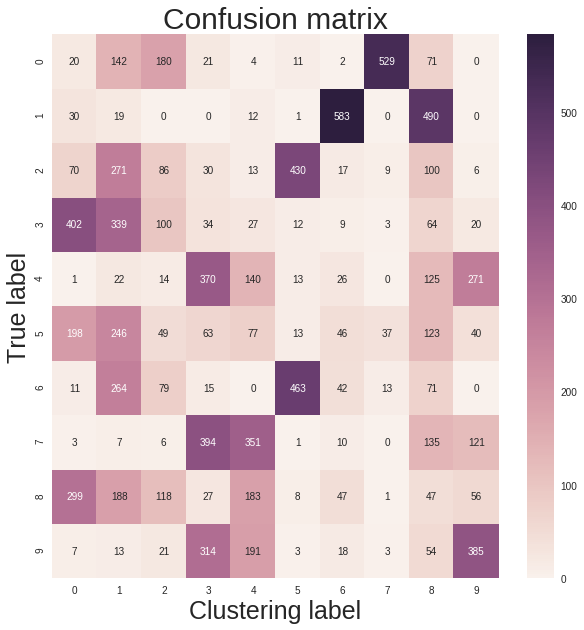

In [61]:

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns


kmeans = KMeans(n_clusters=10)
cl = kmeans.fit_predict(encoded_imgs)

# comparaison des resultats du clustering avec la confusion matrix
cm = confusion_matrix(y_test, cl)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('Labels d\'origine, fontsize=25)
plt.xlabel('labels Clustering', fontsize=25)
plt.show()

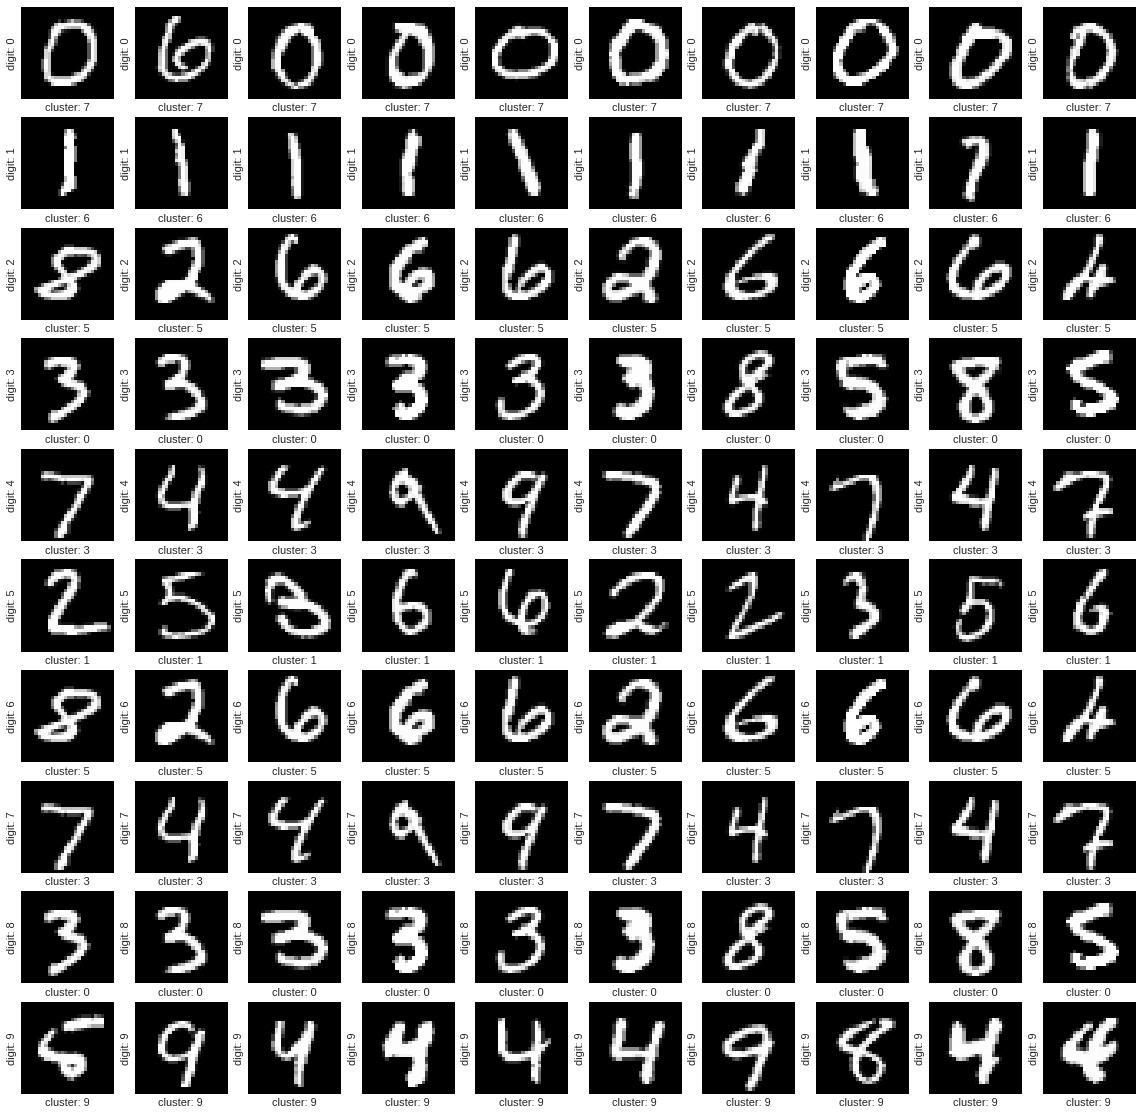

In [64]:
# Les images regroupées par cluster 
fig = plt.figure(figsize=(20,20))
for r in range(10):
    cluster = cm[r].argmax()
    for c, val in enumerate(x_test[cl == cluster][0:10]):
        fig.add_subplot(10, 10, 10*r+c+1)
        plt.imshow(val.reshape((28,28)))
        plt.gray()
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('cluster: '+str(cluster))
        plt.ylabel('digit: '+str(r))
        
        
plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

In [59]:
#@title
from sklearn.cluster import KMeans
labels_true = y_train 
titles = ['LLE + AE']
for n_clusters_ in [2,3]:
  estimators = [('AE + LLE' , KMeans(n_clusters=n_clusters_), encoded_imgs),
                ('AE relu', KMeans(n_clusters=n_clusters_), encoded_imgs)]

  print(type(y))
  print('Number of clusters: %d' % n_clusters_)
  for name, est, data in estimators:
      X = data
      est.fit(X)
      labels = est.labels_
      print(name,':')
      print(labels[:]) 
      print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
      print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
      print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
      print("Adjusted Rand Index: %0.3f"
            % metrics.adjusted_rand_score(labels_true, labels))
      print("Adjusted Mutual Information: %0.3f"
            % metrics.adjusted_mutual_info_score(labels_true, labels))
      print("Silhouette Coefficient: %0.3f"
            % metrics.silhouette_score(X, labels))
      print()
  print()
  print('----------------------------------------------------------------------------------')
print()

<class 'numpy.ndarray'>
Number of clusters: 2
AE + LLE :
[1 1 1 ... 0 1 0]


NameError: ignored